In [22]:
!pip install xgboost mlflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split # Re-introduce for validation split
import joblib
import mlflow
import mlflow.sklearn

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## Data Prepocessing

In [4]:
train_filepath = 'data/train.csv'
test_filepath = 'data/test.csv'
train_df = None
test_df = None
preprocessor = None # To store the ColumnTransformer pipeline
X_train = None
y_train = None
X_test_processed_for_prediction = None # Processed test features
test_ids = None # To store ids from test.csv for submission
numerical_features = []
categorical_features = []
text_features = []
date_features = []
target_variable = 'Premium Amount' 

## Load the training and test datasets from the specified filepaths.

In [8]:
print(f"Loading training data from: {train_filepath}")
print(f"Loading test data from: {test_filepath}")

try:
    train_df = pd.read_csv(train_filepath)
    test_df = pd.read_csv(test_filepath)
    print("Data loaded successfully.")

    # Store test ids for later submission
    if 'id' in test_df.columns: 
        test_ids = test_df['id']
        # Drop id from test_df so it's not treated as a feature
        test_df = test_df.drop(columns=['id'])
    else:
        print("Warning: 'id' column not found in test.csv. Cannot store test ids.")
except FileNotFoundError:
    print(f"Error: Dataset not found. Check paths: {train_filepath}, {test_filepath}")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Loading training data from: data/train.csv
Loading test data from: data/test.csv
Data loaded successfully.


## Performs initial Exploratory Data Analysis (EDA) on the loaded training dataset.

In [12]:
if train_df is None:
    print("No training data loaded. Please call load_data() first.")
else:
    print("\n--- Initial Training Data Exploration ---")
    print(f"Training Dataset Shape: {train_df.shape} (rows, columns)")
    print("\nFirst 5 rows (Training):")
    print(train_df.head())
    print("\nTraining Dataset Info:")
    train_df.info()
    print("\nMissing Values (before handling - Training):")
    print(train_df.isnull().sum())
    print("\nDescriptive Statistics for Numerical Features (Training):")
    print(train_df.describe().T)

    # identify feature types based on training data
    numerical_features = train_df.select_dtypes(include=np.number).columns.tolist()
    if target_variable in numerical_features:
        numerical_features.remove(target_variable)

    categorical_features = train_df.select_dtypes(include='object').columns.tolist()

    if 'Customer Feedback' in categorical_features:
        text_features.append('Customer Feedback')
        categorical_features.remove('Customer Feedback')
    if 'Policy Start Date' in categorical_features:
        date_features.append('Policy Start Date')
        categorical_features.remove('Policy Start Date')
    if 'id' in numerical_features:
        numerical_features.remove('id')

    print(f"\nNumerical Features: {numerical_features}")
    print(f"Categorical Features: {categorical_features}")
    print(f"Text Features (will be ignored): {text_features}")
    print(f"Date Features (will be ignored): {date_features}")

    # Basic EDA for test data
    if test_df is not None:
        print("\n--- Initial Test Data Exploration ---")
        print(f"Test Dataset Shape: {test_df.shape} (rows, columns)")
        print("\nTest Dataset Info:")
        test_df.info()
        print("\nMissing Values (before handling - Test):")
        print(test_df.isnull().sum())


--- Initial Training Data Exploration ---
Training Dataset Shape: (1200000, 21) (rows, columns)

First 5 rows (Training):
   id   Age  Gender  Annual Income Marital Status  Number of Dependents  \
0   0  19.0  Female        10049.0        Married                   1.0   
1   1  39.0  Female        31678.0       Divorced                   3.0   
2   2  23.0    Male        25602.0       Divorced                   3.0   
3   3  21.0    Male       141855.0        Married                   2.0   
4   4  21.0    Male        39651.0         Single                   1.0   

  Education Level     Occupation  Health Score  Location  ... Previous Claims  \
0      Bachelor's  Self-Employed     22.598761     Urban  ...             2.0   
1        Master's            NaN     15.569731     Rural  ...             1.0   
2     High School  Self-Employed     47.177549  Suburban  ...             1.0   
3      Bachelor's            NaN     10.938144     Rural  ...             1.0   
4      Bachelor's  Se

## Visualize distributions of key numerical and categorical features in the training data.


--- Visualizing Distributions (Training Data) ---


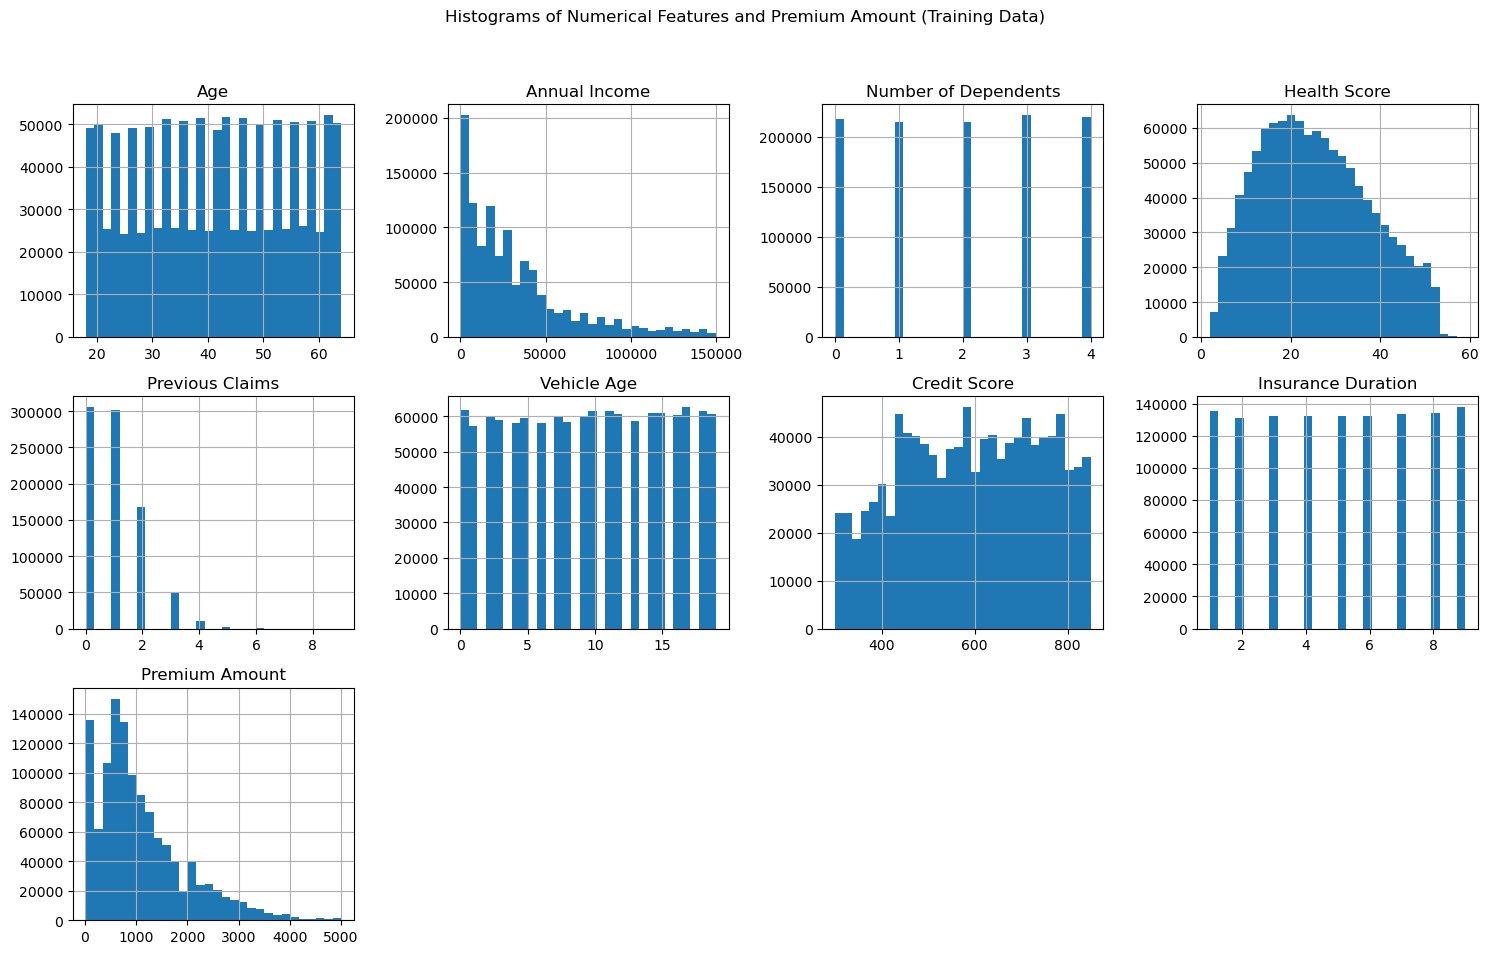

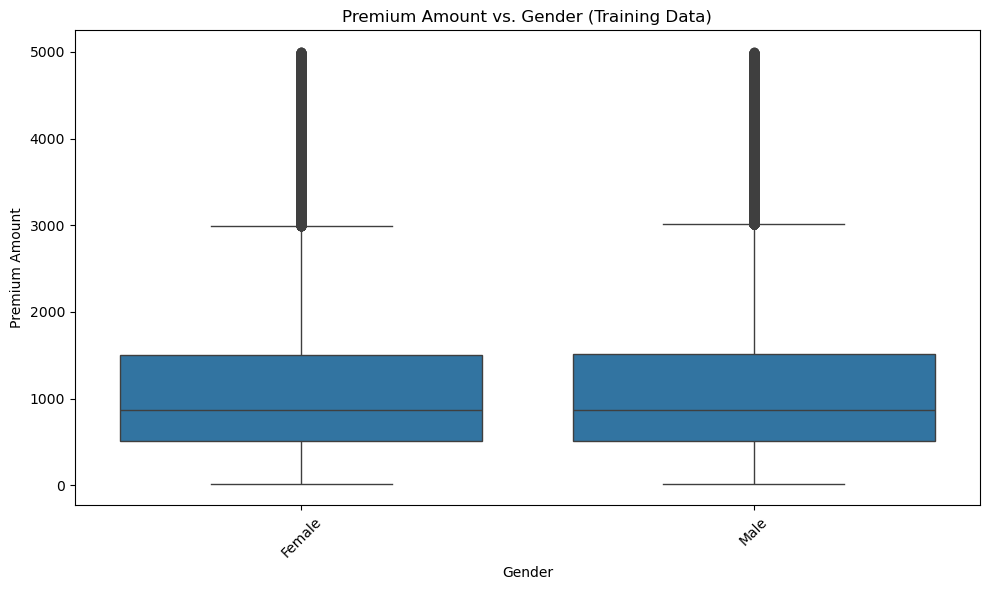

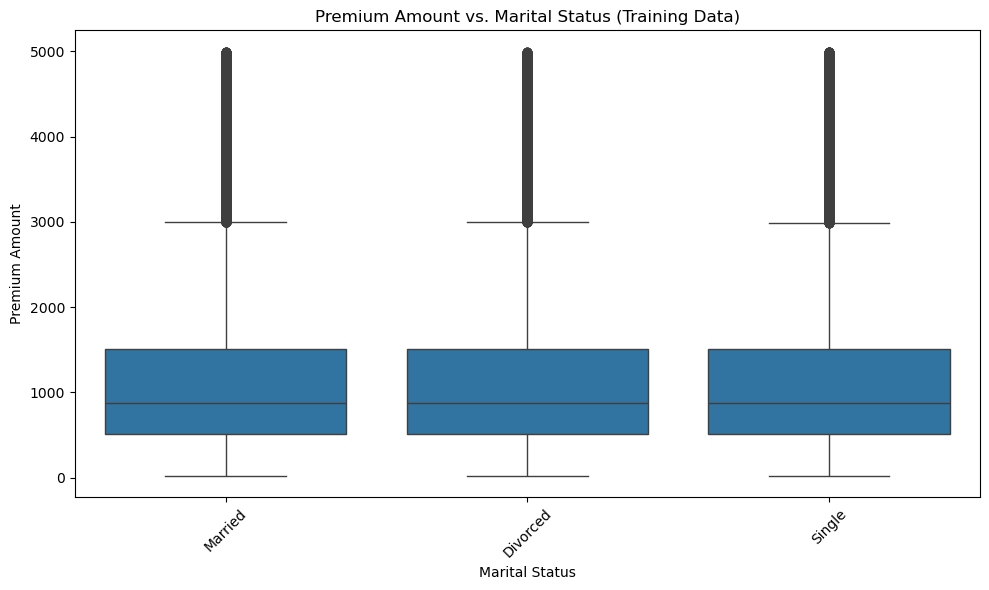

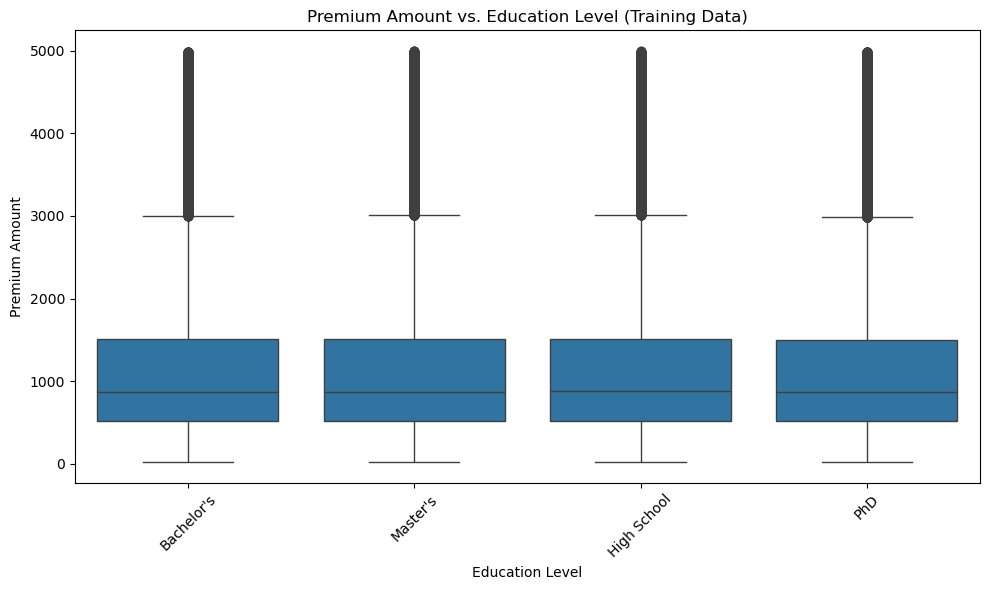

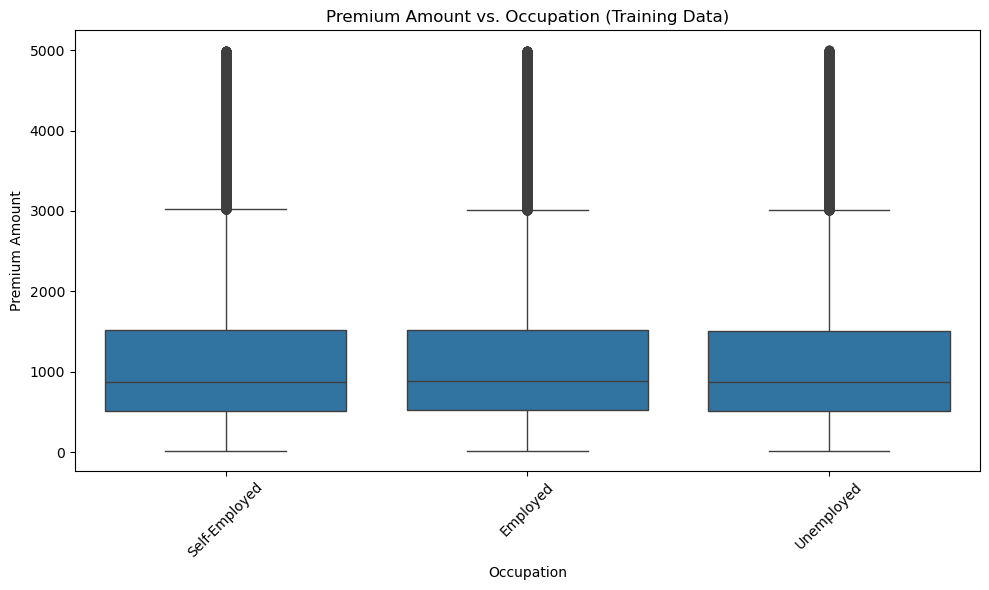

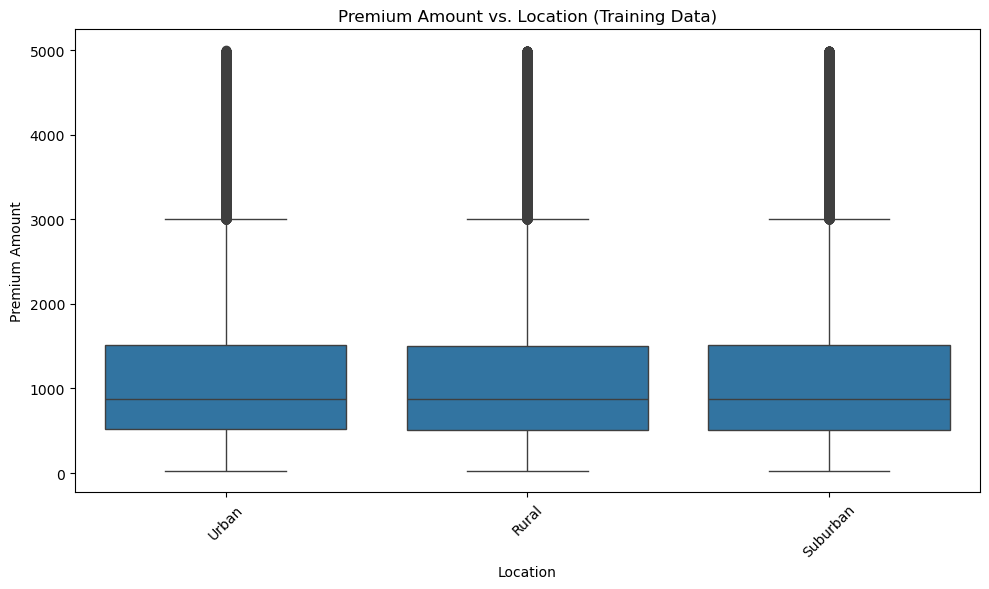

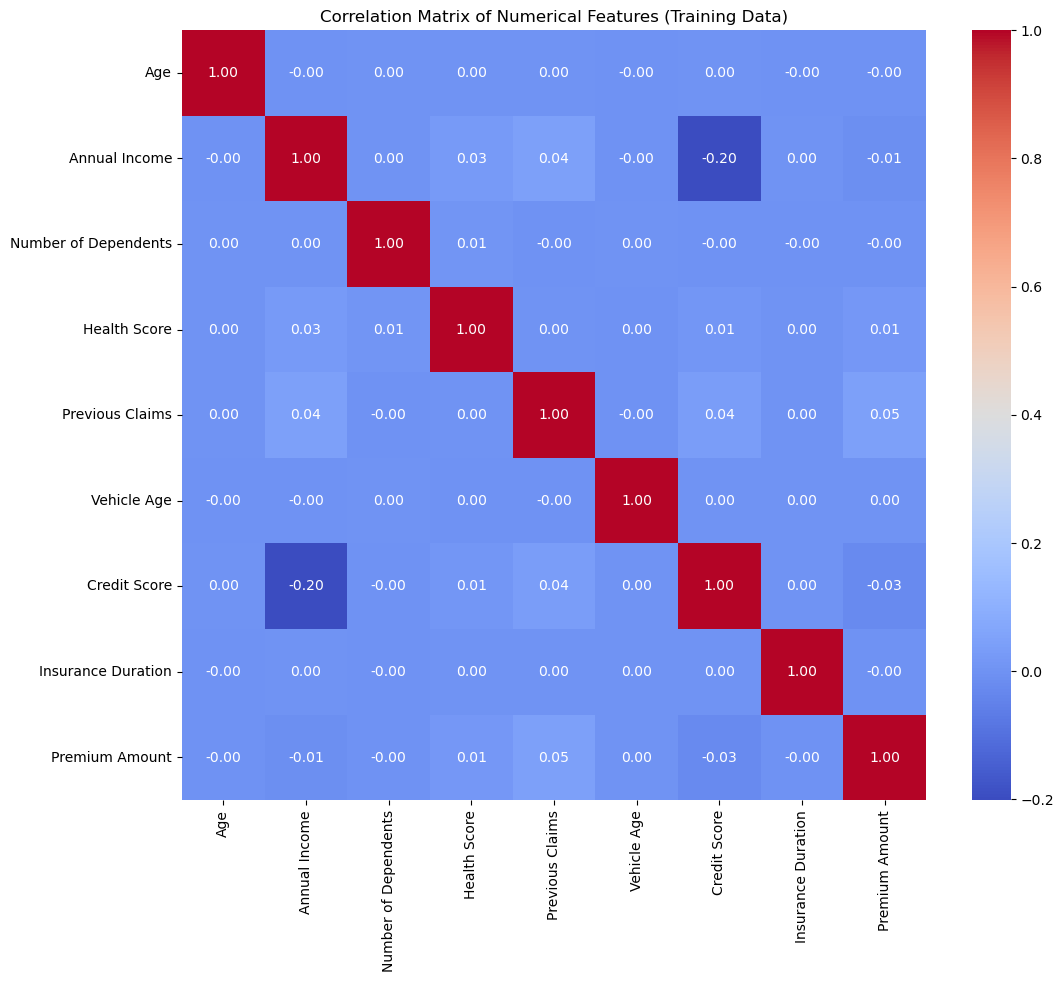

In [13]:
if train_df is None:
    print("No training data loaded. Please call load_data() first.")
else:
    print("\n--- Visualizing Distributions (Training Data) ---")

    # Histograms for numerical features
    train_df[numerical_features + [target_variable]].hist(bins=30, figsize=(15, 10), layout=(3, 4))
    plt.suptitle('Histograms of Numerical Features and Premium Amount (Training Data)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Box plots for target variable vs. categorical features (top N)
    for col in categorical_features[:5]: # Plotting for a few to avoid too many plots
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=col, y=target_variable, data=train_df)
        plt.title(f'{target_variable} vs. {col} (Training Data)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Correlation Heatmap for numerical features
    plt.figure(figsize=(12, 10))
    sns.heatmap(train_df[numerical_features + [target_variable]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features (Training Data)')
    plt.show()

## Performs data preprocessing

In [17]:
if train_df is None or test_df is None:
    print("Training or test data not loaded. Cannot preprocess.")
else:
    print("\n--- Starting Data Preprocessing ---")

    train_df = train_df.copy()
    test_df = test_df.copy()

    # 1. Handle Incorrect Data Types and Derived Features (dropping for now)
    cols_to_drop = []
    if 'Policy Start Date' in train_df.columns:
        cols_to_drop.append('Policy Start Date')
    if 'Customer Feedback' in train_df.columns:
        cols_to_drop.append('Customer Feedback')
    if 'id' in train_df.columns:
        cols_to_drop.append('id')

    if cols_to_drop:
        print(f"Dropping columns: {cols_to_drop} from train and test data.")
        train_df = train_df.drop(columns=cols_to_drop)
        # Ensure these columns exist in test_df before dropping
        for col in cols_to_drop:
            if col in test_df.columns:
                test_df = test_df.drop(columns=[col])

    # Update numerical and categorical features after dropping columns
    numerical_features = train_df.select_dtypes(include=np.number).columns.tolist()
    if target_variable in numerical_features: 
        numerical_features.remove(target_variable)
    categorical_features = train_df.select_dtypes(include='object').columns.tolist()

    print(f"Numerical Features (after initial cleaning): {numerical_features}")
    print(f"Categorical Features (after initial cleaning): {categorical_features}")

    # Define preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    print("\nPreprocessing pipeline created:")
    print(preprocessor)

    # Separate features (X) and target (y) for training data
    X_train = train_df.drop(columns=[target_variable])
    y_train = train_df[target_variable]

    print("Data preprocessing setup complete.")


--- Starting Data Preprocessing ---
Numerical Features (after initial cleaning): ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
Categorical Features (after initial cleaning): ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Preprocessing pipeline created:
ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Annual Income',
                                  'Number of Dependents', 'Health Score',
                                  'Previous Claims', 'Vehicle Age',
                                  'Credit Sco

## Model Training

In [23]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
}
best_model_pipeline = None # Stores the full pipeline (preprocessor + best model)
best_model_name = None
mlflow.set_experiment("Insurance Premium Prediction (Train/Validation Split)")

2025/08/29 01:25:29 INFO mlflow.tracking.fluent: Experiment with name 'Insurance Premium Prediction (Train/Validation Split)' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/Sanjeev/Documents/Guvi/GuviSmartPremium/mlruns/876946718752854240', creation_time=1756410929176, experiment_id='876946718752854240', last_update_time=1756410929176, lifecycle_stage='active', name='Insurance Premium Prediction (Train/Validation Split)', tags={}>

## Splits the provided full training data into training and validation sets.

In [25]:
X_train_full = X_train
y_train_full = y_train
X_train_split = None # Actual training data for model
X_val_split = None   # Validation data for evaluation
y_train_split = None
y_val_split = None
test_size=0.2
random_state=42

print(f"\n--- Splitting Training Data into Train ({(1-test_size)*100}%) and Validation ({test_size*100}%) ---")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_full, y_train_full, test_size=test_size, random_state=random_state)
print(f"X_train_split shape: {X_train_split.shape}")
print(f"X_val_split shape: {X_val_split.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"y_val_split shape: {y_val_split.shape}")
print("Validation split complete.")


--- Splitting Training Data into Train (80.0%) and Validation (20.0%) ---
X_train_split shape: (960000, 17)
X_val_split shape: (240000, 17)
y_train_split shape: (960000,)
y_val_split shape: (240000,)
Validation split complete.


## Trains and evaluates each defined model using the train/validation split

In [26]:
def _calculate_metrics(y_true, y_pred):
    """
    Calculates and returns evaluation metrics.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    y_pred_positive = np.maximum(y_pred, 0)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred_positive + 1e-9)))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'RMSLE': rmsle
    }

print("\n--- Starting Model Training and Evaluation on Validation Set ---")
best_rmse = float('inf')

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        print(f"\nTraining and evaluating: {name}")

        # Build the full pipeline: preprocessor + model
        # The preprocessor is fit on X_train_split and then transforms both splits
        full_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        # Train the model on the X_train_split
        full_pipeline.fit(X_train_split, y_train_split)

        # Make predictions on the validation set
        y_pred_val = full_pipeline.predict(X_val_split)
        val_metrics = _calculate_metrics(y_val_split, y_pred_val)

        # Also get train metrics for comparison 
        y_pred_train = full_pipeline.predict(X_train_split)
        train_metrics = _calculate_metrics(y_train_split, y_pred_train)


        print(f"--- {name} Results ---")
        print("Train Metrics:", train_metrics)
        print("Validation Metrics:", val_metrics) 

        # MLflow Logging
        mlflow.log_params({
            "model_name": name,
            "target_variable": "Premium Amount",
            "validation_split_ratio": 0.2
        })
        mlflow.log_metrics({f"train_{k.lower()}": v for k, v in train_metrics.items()})
        mlflow.log_metrics({f"validation_{k.lower()}": v for k, v in val_metrics.items()}) 

        mlflow.sklearn.log_model(full_pipeline, "model")

        # Check for the best model based on validation RMSE
        if val_metrics['RMSE'] < best_rmse:
            best_rmse = val_metrics['RMSE']
            best_model_pipeline = full_pipeline
            best_model_name = name
            print(f"New best model found: {name} with Validation RMSE: {val_metrics['RMSE']:.4f}")

print(f"\n--- Model Training and Evaluation Complete ---")
if best_model_pipeline:
    print(f"Best Model Selected: {best_model_name} with Validation RMSE: {best_rmse:.4f}")
else:
    print("No models were trained.")


--- Starting Model Training and Evaluation on Validation Set ---


2025/08/29 01:38:39 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet




Training and evaluating: Linear Regression


2025/08/29 01:38:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--- Linear Regression Results ---
Train Metrics: {'RMSE': np.float64(863.9411600360811), 'MAE': 667.650381650038, 'R2': 0.0027553640448235717, 'RMSLE': np.float64(1.1680080913014572)}
Validation Metrics: {'RMSE': np.float64(863.3448726003656), 'MAE': 667.3418417545854, 'R2': 0.0025709275204798265, 'RMSLE': np.float64(1.1687508849987343)}


2025/08/29 01:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


New best model found: Linear Regression with Validation RMSE: 863.3449

Training and evaluating: Decision Tree


2025/08/29 01:39:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--- Decision Tree Results ---
Train Metrics: {'RMSE': np.float64(0.0), 'MAE': 0.0, 'R2': 1.0, 'RMSLE': np.float64(8.00979982159176e-12)}
Validation Metrics: {'RMSE': np.float64(1239.51518774647), 'MAE': 904.6413291666667, 'R2': -1.0559715444564621, 'RMSLE': np.float64(1.522680018273057)}


2025/08/29 01:39:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training and evaluating: Random Forest


2025/08/29 02:02:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--- Random Forest Results ---
Train Metrics: {'RMSE': np.float64(321.1999396443404), 'MAE': 245.64859560416664, 'R2': 0.8621571358347182, 'RMSLE': np.float64(0.7493140868632523)}
Validation Metrics: {'RMSE': np.float64(857.3238200249527), 'MAE': 662.7967070000002, 'R2': 0.016434752616980353, 'RMSLE': np.float64(1.1689156102623732)}


2025/08/29 02:02:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


New best model found: Random Forest with Validation RMSE: 857.3238

Training and evaluating: XGBoost


2025/08/29 02:03:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--- XGBoost Results ---
Train Metrics: {'RMSE': np.float64(838.8102616997281), 'MAE': 639.763306167984, 'R2': 0.059928582856606405, 'RMSLE': np.float64(1.141509774020232)}
Validation Metrics: {'RMSE': np.float64(848.5585153488449), 'MAE': 647.0798827640335, 'R2': 0.03644394145827701, 'RMSLE': np.float64(1.1501505037649236)}


2025/08/29 02:03:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


New best model found: XGBoost with Validation RMSE: 848.5585

--- Model Training and Evaluation Complete ---
Best Model Selected: XGBoost with Validation RMSE: 848.5585


## Saves the best performing model pipeline.

In [29]:
path = 'models/best_insurance_premium_model.pkl'
if best_model_pipeline:
    joblib.dump(best_model_pipeline, path)
    print(f"Best model pipeline saved to {path}")
else:
    print("No best model pipeline found to save.")

Best model pipeline saved to models/best_insurance_premium_model.pkl


In [30]:
best_model = best_model_pipeline
if best_model and test_df is not None and test_ids is not None:
    print("\n--- Making predictions on test.csv data ---")
    final_predictions = best_model.predict(test_df)
    final_predictions = np.maximum(final_predictions, 0) 

    # Create submission file
    submission_df = pd.DataFrame({
        'ID': test_ids,
        'Premium Amount': final_predictions
    })
    submission_filepath = 'data/submission.csv' 
    submission_df.to_csv(submission_filepath, index=False)
    print(f"Final predictions saved to {submission_filepath}")
    print(submission_df.head())
else:
    print("Could not make final predictions on test.csv. Model or test data missing.")


--- Making predictions on test.csv data ---
Final predictions saved to data/submission.csv
        ID  Premium Amount
0  1200000     1623.664429
1  1200001     1178.453613
2  1200002     1063.702759
3  1200003     1069.759766
4  1200004     1027.898315


## Data Prediction

In [31]:
class PremiumPredictor:
    """
    A class to load the trained model and make insurance premium predictions.
    The loaded model is a pipeline that handles preprocessing internally.
    """
    def __init__(self, model_path='models/best_insurance_premium_model.pkl'):
        """
        Initializes the predictor by loading the trained model pipeline.

        Args:
            model_path (str): Path to the saved model pipeline (.pkl file).
        """
        self.model = None
        self.model_path = model_path
        self._load_model()

    def _load_model(self):
        """
        Loads the trained machine learning model pipeline from the specified path.
        """
        try:
            self.model = joblib.load(self.model_path)
            print(f"Model loaded successfully from {self.model_path}")
        except FileNotFoundError:
            print(f"Error: Model file not found at {self.model_path}. "
                  "Please ensure you have run model_training.py and the model is saved.")
            self.model = None
        except Exception as e:
            print(f"An error occurred while loading the model: {e}")
            self.model = None

    def predict_premium(self, customer_data: pd.DataFrame):
        """
        Predicts the insurance premium for new customer data.

        Args:
            customer_data (pd.DataFrame): A Pandas DataFrame containing the
                                         raw features of the customer(s) for whom
                                         to predict the premium.
                                         Column names must match the original
                                         training data features (excluding target, id, etc.)
                                         before preprocessing.

        Returns:
            np.array: An array of predicted insurance premiums.
                      Returns None if the model is not loaded.
        """
        if self.model is None:
            print("Model not loaded. Cannot make predictions.")
            return None

        try:
            predictions = self.model.predict(customer_data)
            # Ensure predictions are non-negative, as premiums cannot be negative
            return np.maximum(predictions, 0)
        except Exception as e:
            print(f"Error during prediction: {e}")
            return None

if __name__ == "__main__":
    predictor = PremiumPredictor()

    if predictor.model:
        # Creating a sample DataFrame matching the expected input features
        sample_customer_data = pd.DataFrame([{
            'Age': 30,
            'Gender': 'Male',
            'Annual Income': 60000,
            'Marital Status': 'Married',
            'Number of Dependents': 2,
            'Education Level': 'Bachelor\'s',
            'Occupation': 'Employed',
            'Health Score': 75,
            'Location': 'Urban',
            'Policy Type': 'Comprehensive',
            'Previous Claims': 0,
            'Vehicle Age': 5,
            'Credit Score': 720,
            'Insurance Duration': 3,
            'Smoking Status': 'No',
            'Exercise Frequency': 'Weekly',
            'Property Type': 'House'
        },
        {
            'Age': 45,
            'Gender': 'Female',
            'Annual Income': 90000,
            'Marital Status': 'Divorced',
            'Number of Dependents': 1,
            'Education Level': 'Master\'s',
            'Occupation': 'Self-Employed',
            'Health Score': 88,
            'Location': 'Suburban',
            'Policy Type': 'Premium',
            'Previous Claims': 1,
            'Vehicle Age': 2,
            'Credit Score': 680,
            'Insurance Duration': 5,
            'Smoking Status': 'Yes',
            'Exercise Frequency': 'Daily',
            'Property Type': 'Apartment'
        }])

        print("\nSample customer data for prediction:")
        print(sample_customer_data)

        predicted_premiums = predictor.predict_premium(sample_customer_data)

        if predicted_premiums is not None:
            print("\nPredicted Insurance Premiums:")
            for i, premium in enumerate(predicted_premiums):
                print(f"Customer {i+1}: ${premium:.2f}")
        else:
            print("Prediction failed for sample data.")
    else:
        print("Prediction model not available. Cannot run example prediction.")

Model loaded successfully from models/best_insurance_premium_model.pkl

Sample customer data for prediction:
   Age  Gender  Annual Income Marital Status  Number of Dependents  \
0   30    Male          60000        Married                     2   
1   45  Female          90000       Divorced                     1   

  Education Level     Occupation  Health Score  Location    Policy Type  \
0      Bachelor's       Employed            75     Urban  Comprehensive   
1        Master's  Self-Employed            88  Suburban        Premium   

   Previous Claims  Vehicle Age  Credit Score  Insurance Duration  \
0                0            5           720                   3   
1                1            2           680                   5   

  Smoking Status Exercise Frequency Property Type  
0             No             Weekly         House  
1            Yes              Daily     Apartment  

Predicted Insurance Premiums:
Customer 1: $2288.95
Customer 2: $2177.31


## StreamLit App

In [ ]:
!streamlit run Smartpremium.py